In [5]:
import pandas as pd
import numpy as np
import sys

sys.path.append('../../src')
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip

plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['font.size'] = 20

# 小数点以下 桁数 6
pd.options.display.float_format = '{:.3f}'.format


In [6]:
import initial_condition
from process import weight
from visualize import rank as vr


In [44]:
global data_dir, filter_dir, output_dir
data_dir = '../../data/interim/internal/filtered_before_agg/'
filter_dir = '../../data/interim/internal/filter_after_agg/'
output_dir = '../../data/interim/internal/filtered_after_agg/'
ex_dir = '../../data/processed/external/schmoch/'


In [55]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM
# top_p_or_num = ('p', 100)
region_corporation = initial_condition.REGION_CORPORATION
# region_corporation = 'right_person_addr'
applicant_weight = initial_condition.APPLICANT_WEIGHT

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT

filter_condition = f'{ar}_{year_style}_{extract_population}_reg_num_top_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}'
input_condition = f'{ar}_{year_style}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}'



In [18]:
filter_condition

'app_nendo_all_reg_num_top_p_3_right_person_name'

In [21]:
# 全体
all_df = pd.read_csv(f'{data_dir}japan.csv', 
                     encoding='utf-8', 
                     sep=',', 
                     usecols=['reg_num', 
                              region_corporation, 'right_person_addr',
                              f'{ar}_{year_style}', 
                              f'{classification}'], 
                     dtype={'reg_num': str, 
                            region_corporation: str, 
                            f'{ar}_{year_style}': np.int64, 
                            f'{classification}': str})

all_df = all_df[all_df[f'{ar}_{year_style}'].isin(range(year_start, year_end+1))]\
               .drop_duplicates()\
# display(all_df.head())


# 各期間
sep_year_df_dict = {}

for year in range(year_start, year_end+1, year_range):
    sep_year_df_dict[f'{year}-{year+year_range-1}'] = all_df[all_df[f'{ar}_{year_style}'].isin(range(year, year+year_range))]


In [22]:
all_df

,reg_num,right_person_name,app_nendo,schmoch35,right_person_addr
726292,1513806,あしゆ羅工房株式会社,1981,29,大阪府
726293,1448230,あすか製薬株式会社,1981,11,東京都
726294,1466808,あすか製薬株式会社,1981,16,東京都
726297,1535495,あすか製薬株式会社,1981,14,東京都
726298,1557663,あすか製薬株式会社,1981,14,東京都
...,...,...,...,...,...
4615543,5451673,Ｚホールデイングス株式会社,2010,6,東京都
4615546,5989302,ＺＥＮＴＡ株式会社,2010,8,東京都
4615547,5291735,ａｘ株式会社,2010,6,東京都
4615548,5838311,ｉーＰＲＯ株式会社,2010,13,東京都


In [24]:
# 特許分類による重みづけ
# 全体
if class_weight == 'fraction':
    all_df = weight.by_classification(all_df, region_corporation, classification)
elif class_weight == 'duplication':
    all_df['class_weight'] = 1
all_df[f'{ar}_{year_style}_period'] = f'{year_start}-{year_end}'


# 共同出願の重みづけ
# 全体
if applicant_weight == 'fraction':
    all_df = weight.by_applicant(all_df, region_corporation)
elif applicant_weight == 'duplication':
    all_df['applicant_weight'] = 1
all_df[f'{ar}_{year_style}_period'] = f'{year_start}-{year_end}'
all_df


,reg_num,right_person_name,app_nendo,schmoch35,right_person_addr,class_weight,app_nendo_period,applicant_weight
0,1513806,あしゆ羅工房株式会社,1981,29,大阪府,1,1981-2010,2
1,1448230,あすか製薬株式会社,1981,11,東京都,1,1981-2010,1
2,1466808,あすか製薬株式会社,1981,16,東京都,1,1981-2010,1
3,1535495,あすか製薬株式会社,1981,14,東京都,1,1981-2010,1
4,1557663,あすか製薬株式会社,1981,14,東京都,1,1981-2010,1
...,...,...,...,...,...,...,...,...
3590018,5451673,Ｚホールデイングス株式会社,2010,6,東京都,1,1981-2010,2
3590019,5989302,ＺＥＮＴＡ株式会社,2010,8,東京都,1,1981-2010,1
3590020,5291735,ａｘ株式会社,2010,6,東京都,1,1981-2010,1
3590021,5838311,ｉーＰＲＯ株式会社,2010,13,東京都,1,1981-2010,2


In [23]:
# フィルタリング
reg_num_filter_df = pd.read_csv(f'{filter_dir}{filter_condition}.csv',
                                encoding='utf-8',
                                sep=',', 
                                usecols=[f'{ar}_{year_style}_period', region_corporation],
                                dtype=str)
reg_num_filter_df

,app_nendo_period,right_person_name
0,1981-2010,パナソニツクホールデイングス株式会社
1,1981-2010,キヤノン株式会社
2,1981-2010,株式会社東芝
3,1981-2010,日本電気株式会社
4,1981-2010,三菱電機株式会社
...,...,...
1933,1981-2010,モリタ宮田工業株式会社
1934,1981-2010,スピードフアム株式会社
1935,1981-2010,株式会社ＩＨＩ検査計測
1936,1981-2010,株式会社ＪＣＵ


In [33]:
df = pd.merge(all_df, reg_num_filter_df, on=[f'{ar}_{year_style}_period', 'right_person_name'], how='inner')
all_reg_num_df = df.copy()
all_reg_num_df['reg_num'] = 1 / all_reg_num_df['class_weight'] / all_reg_num_df['applicant_weight']
all_reg_num_df = all_reg_num_df.groupby([f'{ar}_{year_style}_period', 'right_person_addr', classification])[['reg_num']]\
                               .sum().reset_index(drop=False)\
                               .sort_values(['reg_num'], ascending=[False])
all_reg_num_df
# sep_year_reg_num_df_dict = sep_year_df_dict.copy()
# for period, sep_year_reg_num_df in sep_year_reg_num_df_dict.items():
#     sep_year_reg_num_df['reg_num'] = 1 / sep_year_reg_num_df['class_weight'] / sep_year_reg_num_df['applicant_weight']
#     sep_year_reg_num_df = sep_year_reg_num_df.groupby([f'{ar}_{year_style}_period', region_corporation, classification])[['reg_num']]\
#                                              .sum().reset_index(drop=False)\
#                                              .sort_values(['reg_num'], ascending=[False])
#     sep_year_reg_num_df_dict[period] = sep_year_reg_num_df
# sep_year_reg_num_df = pd.concat([sep_year_reg_num_df for sep_year_reg_num_df in sep_year_reg_num_df_dict.values()], axis='index', ignore_index=True)
# sep_year_reg_num_df

,app_nendo_period,right_person_addr,schmoch35,reg_num
872,1981-2010,東京都,9,147986.245
849,1981-2010,東京都,2,104252.472
838,1981-2010,東京都,1,97211.040
869,1981-2010,東京都,6,93518.519
839,1981-2010,東京都,10,83408.923
...,...,...,...,...
167,1981-2010,北海道,7,0.333
1236,1981-2010,長崎県,19,0.333
1243,1981-2010,長崎県,35,0.333
1439,1981-2010,鹿児島県,7,0.333


In [39]:
trade_cols = {'time':f'{ar}_{year_style}_period', 'loc':'right_person_addr', 'prod':classification, 'val':'reg_num'}
rename_col_dict = {'eci':'kci', 'pci':'tci'}
col_order_list = [f'{ar}_{year_style}_period', 'right_person_addr', classification, 'reg_num', 'rca', 'mcp', 'diversity', 'ubiquity', 'kci', 'tci']


In [37]:
def kh_ki(c_df, classification, n=19):
    kh1_ki1_df = pd.merge(c_df.copy(), 
                        c_df[c_df['mcp']==1].groupby(['right_person_addr'])[['ubiquity']].sum().reset_index(drop=False).copy().rename(columns={'ubiquity':'kh_1'}), 
                        on=['right_person_addr'], how='left')
    kh1_ki1_df = pd.merge(kh1_ki1_df.copy(), 
                        c_df[c_df['mcp']==1].groupby([classification])[['diversity']].sum().reset_index(drop=False).copy().rename(columns={'diversity':'ki_1'}), 
                        on=[classification], how='left')
    kh1_ki1_df['kh_1'] = kh1_ki1_df['kh_1'] / kh1_ki1_df['diversity']
    kh1_ki1_df['ki_1'] = kh1_ki1_df['ki_1'] / kh1_ki1_df['ubiquity']
    kh_ki_df = kh1_ki1_df.copy()
    for i in range(n):
        kh_ki_df = pd.merge(kh_ki_df, 
                            kh_ki_df[kh_ki_df['mcp']==1].groupby(['right_person_addr'])[[f'ki_{i+1}']].sum().reset_index(drop=False).copy()\
                                        .rename(columns={f'ki_{i+1}':f'kh_{i+2}'}), 
                            on=['right_person_addr'], how='left')
        kh_ki_df = pd.merge(kh_ki_df, 
                            kh_ki_df[kh_ki_df['mcp']==1].groupby([classification])[[f'kh_{i+1}']].sum().reset_index(drop=False).copy()\
                                        .rename(columns={f'kh_{i+1}':f'ki_{i+2}'}), 
                            on=[classification], how='left')
        kh_ki_df[f'kh_{i+2}'] = kh_ki_df[f'kh_{i+2}'] / kh_ki_df['diversity']
        kh_ki_df[f'ki_{i+2}'] = kh_ki_df[f'ki_{i+2}'] / kh_ki_df['ubiquity']
    return kh_ki_df


In [104]:
c_df = ecomplexity(all_reg_num_df,
                   cols_input = trade_cols, 
                   rca_mcp_threshold = 1)
# c_out_df = c_df.copy()
c_df = c_df[c_df['reg_num'] > 0]\
           .rename(columns=rename_col_dict)\
           [col_order_list]
c_df = pd.concat([kh_ki(c_df[c_df[f'{ar}_{year_style}_period'] == period], classification) for period in c_df[f'{ar}_{year_style}_period'].unique()], 
                 axis='index', 
                 ignore_index=True)
c_df[classification] = c_df[classification].astype(int)
schmoch_df = pd.read_csv(f'{ex_dir}35.csv', 
                         encoding='utf-8', 
                         sep=',', 
                         usecols=['Field_number', 'Field_en']
                         ).drop_duplicates()

c_df = pd.merge(c_df, 
                schmoch_df, 
                left_on=[classification], 
                right_on=['Field_number'], 
                how='left').drop(columns=['Field_number', classification]).rename(columns={'Field_en': classification})
# c_df = c_df[[f'{ar}_{year_style}_period', classification, 'tci']]
pre_df = c_df[[f'{ar}_{year_style}_period', classification, 'tci']].copy()

1981-2010


In [57]:
co_df = pd.read_csv(f'../../data/processed/internal/technology/{input_condition}.csv', 
                    encoding='utf-8',
                    sep=','
                    )[[f'{ar}_{year_style}_period', classification, 'tci']]
co_df

,app_nendo_period,schmoch35,tci
0,1981-1990,"Electrical machinery, apparatus, energy",-1.355
1,1981-2010,"Electrical machinery, apparatus, energy",-0.971
2,1991-2000,"Electrical machinery, apparatus, energy",-0.988
3,2001-2010,"Electrical machinery, apparatus, energy",-0.797
4,1981-1990,Audio-visual technology,-2.368
...,...,...,...
135,2001-2010,Other consumer goods,0.181
136,1981-1990,Civil engineering,0.077
137,1981-2010,Civil engineering,0.459
138,1991-2000,Civil engineering,0.381


In [62]:
eu_df = pd.read_csv('../../data/processed/external/abroad/eu.csv', 
                    encoding='utf-8', 
                    sep=',')
eu_df

,schmoch35,schmoch5,reg_num_eu,TCI_eu,period
0,Digital communication,Electrical engineering,24566,100.000,1985-2009
1,Telecommunications,Electrical engineering,34007,96.970,1985-2009
2,Computer technology,Electrical engineering,34246,93.940,1985-2009
3,Audio-visual technology,Electrical engineering,21662,90.910,1985-2009
4,IT methods for management,Electrical engineering,5565,87.880,1985-2009
5,Pharmaceuticals,Chemistry,62999,84.850,1985-2009
6,Organic fine chemistry,Chemistry,99687,81.820,1985-2009
7,Basic communication processes,Electrical engineering,6284,78.790,1985-2009
8,Optics,Instruments,17771,75.760,1985-2009
9,Semiconductors,Electrical engineering,17315,72.730,1985-2009


In [72]:
pre_co_df = pd.merge(pre_df.rename(columns={'tci':'pre_tci'}), co_df.rename(columns={'tci':'co_tci'}), on=[f'{ar}_{year_style}_period', classification], how='inner')
pre_co_df = pd.merge(pre_co_df, eu_df[['schmoch35', 'schmoch5']], on='schmoch35', how='left')
pre_co_df['schmoch5'] = pre_co_df['schmoch5'].replace('Mechanical engineering', 'Mechanical engineering, machinery')
pre_co_df['schmoch5'] = pre_co_df['schmoch5'].replace('Chemistry', 'Chemistry, pharmaceuticals')
pre_co_df['co_tci'] = (pre_co_df['co_tci'] - pre_co_df['co_tci'].min()) / (pre_co_df['co_tci'].max() - pre_co_df['co_tci'].min()) * 100
pre_co_df['pre_tci'] = (pre_co_df['pre_tci'] - pre_co_df['pre_tci'].min()) / (pre_co_df['pre_tci'].max() - pre_co_df['pre_tci'].min()) * 100
pre_co_df = pre_co_df.drop_duplicates().reset_index(drop=True)
pre_co_df['schmoch5'] = np.where(pre_co_df['schmoch35']=='Machine tools', 
                                 'Mechanical engineering, machinery', 
                                 np.where(pre_co_df['schmoch35']=='Analysis of biological materials', 
                                          'Instruments', 
                                          pre_co_df['schmoch5']))
pre_co_df['co_tci_rank'] = pre_co_df['co_tci'].rank(ascending=False, method='min')
pre_co_df['pre_tci_rank'] = pre_co_df['pre_tci'].rank(ascending=False, method='min')
pre_co_df


,app_nendo_period,schmoch35,pre_tci,co_tci,schmoch5,co_tci_rank,pre_tci_rank
0,1981-2010,"Electrical machinery, apparatus, energy",87.420,51.730,Electrical engineering,27.000,20.000
1,1981-2010,Measurement,84.137,59.253,Instruments,24.000,23.000
2,1981-2010,Analysis of biological materials,91.406,89.644,Instruments,7.000,16.000
3,1981-2010,Control,78.594,34.693,Instruments,30.000,26.000
4,1981-2010,Medical technology,85.490,80.145,Electrical engineering,13.000,22.000
5,1981-2010,Organic fine chemistry,94.168,98.975,"Chemistry, pharmaceuticals",2.000,7.000
6,1981-2010,Biotechnology,91.926,94.653,Instruments,4.000,12.000
7,1981-2010,Pharmaceuticals,91.834,100.000,"Chemistry, pharmaceuticals",1.000,13.000
8,1981-2010,"Macromolecular chemistry, polymers",96.736,93.807,"Chemistry, pharmaceuticals",5.000,4.000
9,1981-2010,Food chemistry,95.196,96.058,"Chemistry, pharmaceuticals",3.000,6.000


In [133]:
sample_df = all_df[~(all_df['right_person_name'].isin(df['right_person_name']))].copy()
sample_df[classification] = sample_df[classification].astype(int)
sample_df = pd.merge(sample_df, schmoch_df, left_on=[classification], right_on=['Field_number'], how='left').drop(columns=['Field_number', classification]).rename(columns={'Field_en': classification})
sample_df = pd.merge(sample_df, eu_df[['schmoch35', 'schmoch5']], on='schmoch35', how='left')\
                [[classification, 'schmoch5', 'reg_num', 'right_person_name', 'right_person_addr']]
sample_df['schmoch5'] = sample_df['schmoch5'].replace('Mechanical engineering', 'Mechanical engineering, machinery')
sample_df['schmoch5'] = sample_df['schmoch5'].replace('Chemistry', 'Chemistry, pharmaceuticals')
sample_df['schmoch5'] = np.where(sample_df['schmoch35']=='Machine tools', 
                                 'Mechanical engineering, machinery', 
                                 np.where(sample_df['schmoch35']=='Analysis of biological materials', 
                                          'Instruments', 
                                          sample_df['schmoch5']))
print(sample_df['schmoch35'].unique())
sample_df[sample_df['schmoch35']=='Digital communication'].groupby([classification, 'right_person_addr'], as_index=False).nunique().sort_values(['right_person_name'], ascending=[False])
sample_df.groupby([classification], as_index=False).nunique().sort_values(['right_person_name'], ascending=[False])
sample_df.groupby([classification, 'right_person_addr'], as_index=False).nunique().sort_values(['reg_num', classification], ascending=False).drop_duplicates(subset=[classification], keep='first')

['Other special machines' 'Transport' 'Food chemistry' 'Civil engineering'
 'Handling' 'Other consumer goods' 'Medical technology'
 'Organic fine chemistry' 'Mechanical elements' 'Biotechnology'
 'Audio-visual technology' 'Basic materials chemistry'
 'Chemical engineering' 'Environmental technology' 'Measurement'
 'Textile and paper machines' 'Materials, metallurgy' 'Pharmaceuticals'
 'Optics' 'Basic communication processes' 'Surface technology, coating'
 'Macromolecular chemistry, polymers' 'Thermal processes and apparatus'
 'Analysis of biological materials' 'Engines, pumps, turbines'
 'Furniture, games' 'Control' 'Telecommunications'
 'Electrical machinery, apparatus, energy' 'Semiconductors'
 'Machine tools' 'Computer technology' 'Digital communication'
 'IT methods for management' 'Micro-structural and nano-technology']


,schmoch35,right_person_addr,schmoch5,reg_num,right_person_name
300,Civil engineering,東京都,1,17503,3709
949,Measurement,東京都,1,7946,2443
715,Handling,東京都,1,6060,2263
1248,Other special machines,東京都,1,5987,2170
480,"Electrical machinery, apparatus, energy",東京都,1,5954,1723
668,"Furniture, games",東京都,1,4937,1716
809,Machine tools,東京都,1,4769,1664
1043,Medical technology,東京都,1,4463,1452
253,Chemical engineering,東京都,1,4348,1635
347,Computer technology,東京都,1,4116,1444


In [144]:
c_df[(c_df[classification]=='Civil engineering')]

,app_nendo_period,right_person_addr,reg_num,rca,mcp,diversity,ubiquity,kci,tci,kh_1,...,ki_16,kh_17,ki_17,kh_18,ki_18,kh_19,ki_19,kh_20,ki_20,schmoch35
27,1981-2010,三重県,627.250,2.011,1,8,16,0.662,0.914,17.875,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
62,1981-2010,京都府,490.602,0.143,0,13,16,-0.431,0.914,13.846,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
128,1981-2010,兵庫県,3212.970,1.207,1,17,16,0.523,0.914,15.353,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
163,1981-2010,北海道,63.583,0.542,0,11,16,0.504,0.914,17.727,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
198,1981-2010,千葉県,162.500,0.302,0,15,16,-0.009,0.914,14.600,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
228,1981-2010,和歌山県,2.000,0.018,0,7,16,-0.627,0.914,13.429,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
263,1981-2010,埼玉県,346.479,0.317,0,14,16,0.336,0.914,16.000,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
311,1981-2010,大阪府,25605.585,1.448,1,15,16,0.528,0.914,15.800,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
345,1981-2010,奈良県,24.000,0.466,0,12,16,0.217,0.914,17.083,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering
379,1981-2010,宮城県,63.144,0.306,0,8,16,0.148,0.914,16.500,...,15.472,15.472,12.117,12.117,15.472,15.472,12.117,12.117,15.472,Civil engineering


In [118]:
a = c_df.groupby([classification])[['right_person_addr']].nunique().sort_values(['right_person_addr'], ascending=[False])
b = c_df[[classification, 'ubiquity', 'tci']].drop_duplicates().sort_values(['tci'], ascending=[False])
c = pd.merge(a, b, on=[classification], how='inner').sort_values(['tci'], ascending=[False])
c['decrease_rate'] = 1 - (c['ubiquity'] / c['right_person_addr'])
c

,schmoch35,right_person_addr,ubiquity,tci,decrease_rate
20,Mechanical elements,41,17,1.117,0.585
9,Civil engineering,43,16,0.914,0.628
7,Environmental technology,44,14,0.904,0.682
16,"Macromolecular chemistry, polymers",42,10,0.902,0.762
26,Transport,40,13,0.863,0.675
29,Food chemistry,39,14,0.800,0.641
27,Organic fine chemistry,39,15,0.732,0.615
5,Chemical engineering,44,25,0.678,0.432
22,Thermal processes and apparatus,40,13,0.655,0.675
14,Basic materials chemistry,43,11,0.650,0.744


In [103]:
pre_co_df.drop_duplicates().reset_index(drop=True).sort_values(['co_tci'], ascending=[False])

,app_nendo_period,schmoch35,pre_tci,co_tci,schmoch5,co_tci_rank,pre_tci_rank
7,1981-2010,Pharmaceuticals,91.834,100.000,"Chemistry, pharmaceuticals",1.000,13.000
5,1981-2010,Organic fine chemistry,94.168,98.975,"Chemistry, pharmaceuticals",2.000,7.000
9,1981-2010,Food chemistry,95.196,96.058,"Chemistry, pharmaceuticals",3.000,6.000
6,1981-2010,Biotechnology,91.926,94.653,Instruments,4.000,12.000
8,1981-2010,"Macromolecular chemistry, polymers",96.736,93.807,"Chemistry, pharmaceuticals",5.000,4.000
10,1981-2010,Basic materials chemistry,92.920,91.404,"Chemistry, pharmaceuticals",6.000,10.000
2,1981-2010,Analysis of biological materials,91.406,89.644,Instruments,7.000,16.000
20,1981-2010,Other special machines,91.246,85.766,"Mechanical engineering, machinery",8.000,17.000
14,1981-2010,Chemical engineering,93.346,85.561,"Chemistry, pharmaceuticals",9.000,8.000
12,1981-2010,"Materials, metallurgy",91.713,83.886,"Chemistry, pharmaceuticals",10.000,15.000


1981-2010 0.811


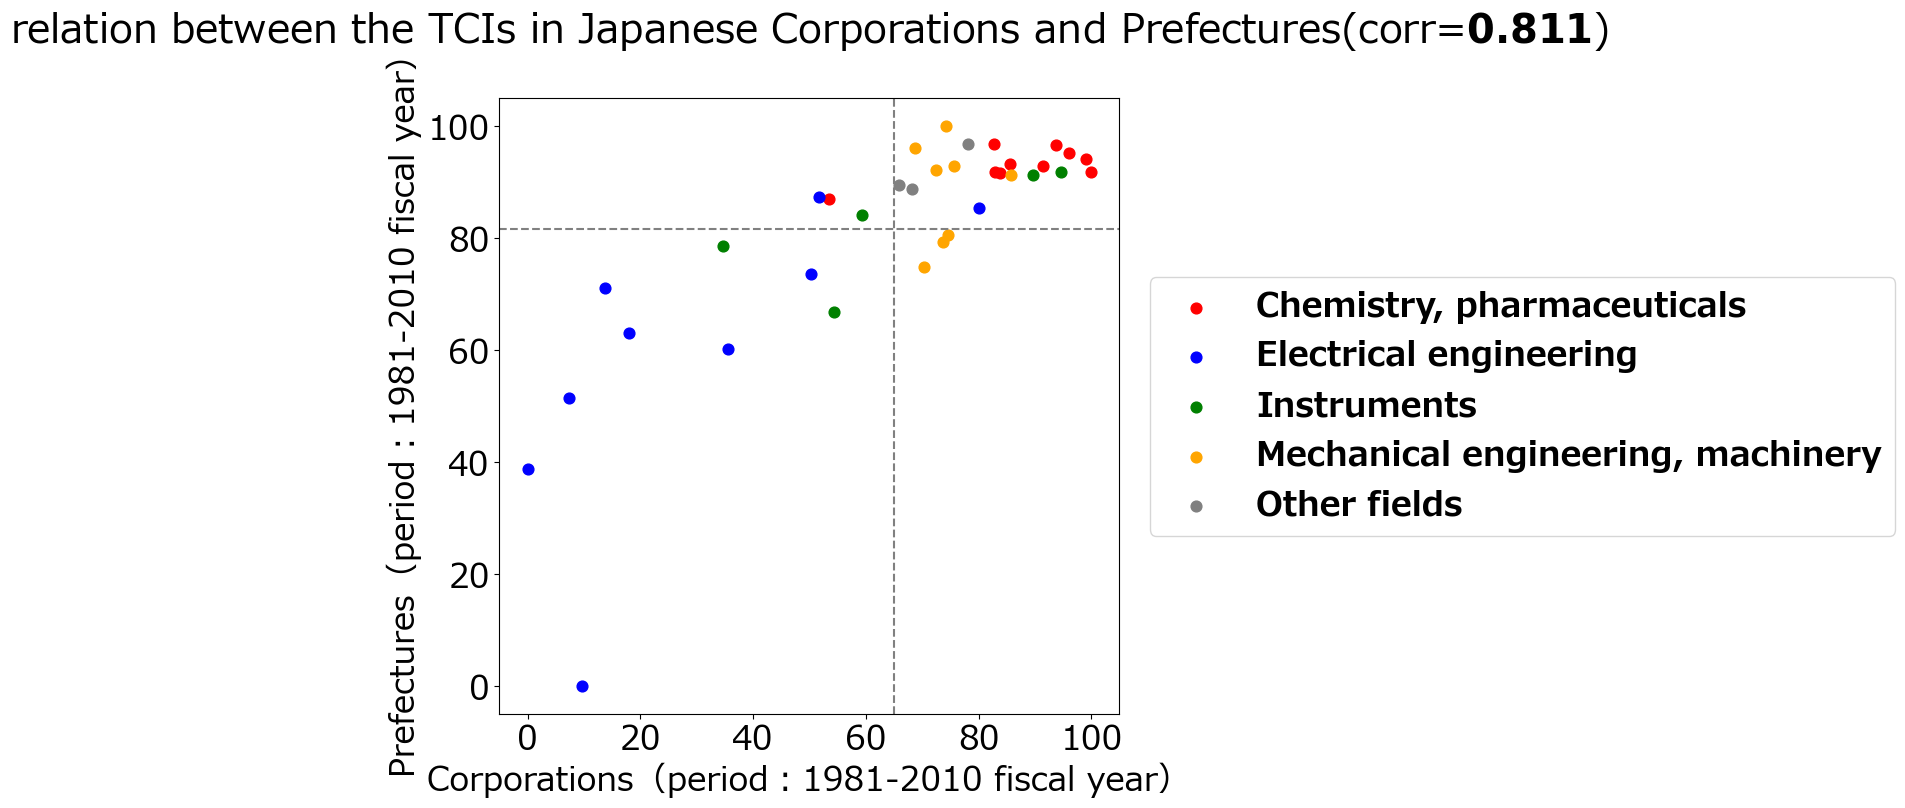

1981-2010 0.761


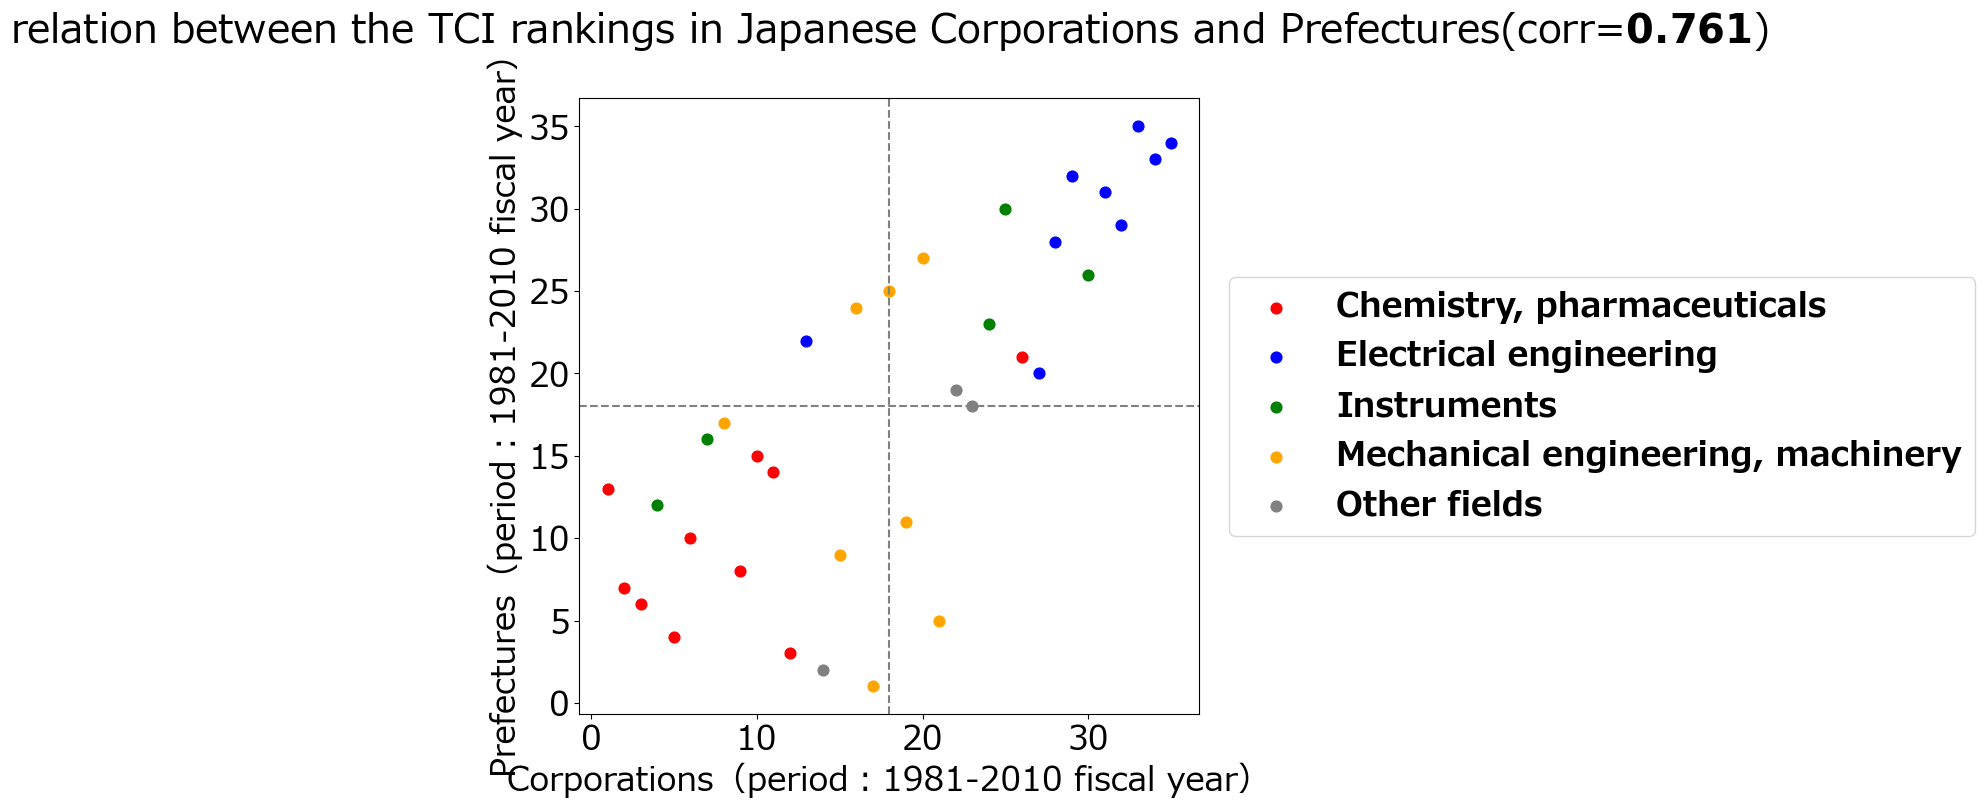

In [143]:
df_dict = {}
tech_color = {
        'Chemistry, pharmaceuticals': 'red',
        'Electrical engineering': 'blue',
        'Instruments': 'green', 
        'Mechanical engineering, machinery': 'orange',
        'Other fields': 'gray'
    }
combi_dict = {  # ind: [x, y, title, xlabel, ylabel, legend_loc]
    1: ["co_tci", "pre_tci", "relation between the TCIs in Japanese Corporations and Prefectures", "Corporations（period：1981-2010 fiscal year）", "Prefectures（period：1981-2010 fiscal year）", "center", ],
    2: ["co_tci_rank", "pre_tci_rank", "relation between the TCI rankings in Japanese Corporations and Prefectures", "Corporations（period：1981-2010 fiscal year）", "Prefectures（period：1981-2010 fiscal year）", "center", ],
    # 2: ["TCI_rank_jp", "TCI_rank_eu", "relation between the TCIs in Japanese corporation and EU regions", "Japanese Corporations ranking（period：1981-2010 fiscal year）", "EU Regions ranking（period：1985-2009 year）", "center", ],
    # 2: ["reg_num_jp", "reg_num_eu", "corr between the patent amounts in Japan and EU", "Japan（period：1981-2010 fiscal year）", "EU（period：1985-2009 year）", "center", ],
    # 3: ["reg_num_jp", "TCI_jp", "relation between the patent counts and the TCIs in Japan", "Patent Counts", "TCIs", "center left", ],
    # 4: ["TCI_jp", "reg_num_jp", "relation between the patent counts and the TCIs in Japan", "TCIs", "Patent Counts", "center left", ],
    # 5: ["reg_num_eu", "TCI_eu", "corr between the patent amounts in EU and TCI in EU", "EU（period：1985-2009 year）", "EU（period：1985-2009 year）", "center", ],
    # 2: ["TCI_eu", "TCI_jp", "corr between the TCIs in Japan and EU", "EU（period：1985-2009 year）", "Japan（period：1981-2010 fiscal year）", "center", ],
}
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Meiryo'
for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f"{year_start}-{year_end}"
    corr_num = round(pre_co_df[combi[0]].corr(pre_co_df[combi[1]]), 3)
    print(period, corr_num)
    # ax.scatter(pre_co_df[combi[0]], pre_co_df[combi[1]],
    #            s=20, alpha=0.8, color="black", )
    # if i == 4:
    ax.axvline(x=pre_co_df[combi[0]].mean(), color="gray", linestyle="--", )
    ax.axhline(y=pre_co_df[combi[1]].mean(), color="gray", linestyle="--", )
    ax.set_title(combi[2]+'(corr=' + r"$\bf{" + str(corr_num)+ "}$" +')\n')
    if combi[0] in ["reg_num"]: ax.set_xscale("log")
    if combi[1] in ["reg_num"]: ax.set_yscale("log")
    x_min = pre_co_df[combi[0]].min()
    x_2smallest = (pre_co_df[combi[0]].nsmallest(2).iloc[1])
    y_2smallest = (pre_co_df[combi[1]].nsmallest(2).iloc[1])
    head_df = pre_co_df.head(5)
    between_df = pre_co_df.iloc[5:len(pre_co_df)-5, :]
    tail_df = pre_co_df.tail(5)
    if i != 5:
        # display(pre_co_df)
        # for i, row in head_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="red")
        #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
        # for i, row in between_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=15, color="black")
        #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
        # for i, row in tail_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="blue", )
        #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
        # for i, row in head_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="red")
            
            # if i == 4: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']], label=row['schmoch5'])
            # else: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']])
        # for i, row in between_df.iterrows():
        #     # ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=15, color="black")
        #     if i == 7: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']], label=row['schmoch5'])
        #     else: ax.scatter(row[combi[0]], row[combi[1]], s=40, color=tech_color[row['schmoch5']])
            
        # for i, row in tail_df.iterrows():
        #     # ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=18, color="blue")
        #     ax.scatter(row[combi[0]], row[combi[1]], s=40, color="blue", label=f'{i+1} {row["schmoch35"]}')
        for tech_color_key in tech_color.keys():
            ax.scatter(pre_co_df[pre_co_df['schmoch5']==tech_color_key][combi[0]], pre_co_df[pre_co_df['schmoch5']==tech_color_key][combi[1]], 
                       color=tech_color[tech_color_key], label=tech_color_key, 
                       s=60)
        # for i, row in pre_co_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=18, color="black")
        # for ind, row in head_df.iterrows():
        #     if ind == 1: ax.text(row[combi[0]]+1, row[combi[1]]-2, f'\n{ind+1} {row["schmoch35"]}', fontsize=20, color=tech_color[row['schmoch5']])
        #     else: ax.text(row[combi[0]]+1, row[combi[1]]-1, f'{ind+1} {row["schmoch35"]}', fontsize=20, color=tech_color[row['schmoch5']])
    # elif i == 2:
    #     for i, row in head_df.iterrows():
    #         ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=18, color="red")
    #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
    #     for i, row in between_df.iterrows():
    #         ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=15, color="black")
    #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
    #     for i, row in tail_df.iterrows():
    #         ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=18, color="blue", )
    #         ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    ax.set_ylabel(combi[4])
    ax.set_xlabel(combi[3])
    # ax.set_xscale('log')
    ax.legend(loc=combi[5], fontsize=20, bbox_to_anchor=(1.65, 0.5), borderaxespad=0, prop={'weight': 'bold'})
    plt.show()
